In [44]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile as wav
from typing import List
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece

sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models')
import helper


In [81]:
# Return hidden score states 

note_info = process_midi_to_note_info('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Bach_1.midi')
dic = notes_to_chords(note_info, sustain=False)
score = dict_to_frequency_list(dic)
print(score[0])

[262]


In [104]:
# Create state transmission matrix, T

# For now we will go with a very simple uniform distribution to the current or next state
K = len(score) # The number of states, K
T = np.zeros((K, K)) 
for i in range(K-1): # Populate transition probabilities except final row
    T[i][i], T[i][i+1] = np.log(0.5), np.log(0.5)
T[-1][-1] = 1 # Update final row so transition probability is one, to itself
print(T)



[[-0.69314718 -0.69314718  0.         ...  0.          0.
   0.        ]
 [ 0.         -0.69314718 -0.69314718 ...  0.          0.
   0.        ]
 [ 0.          0.         -0.69314718 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... -0.69314718 -0.69314718
   0.        ]
 [ 0.          0.          0.         ...  0.         -0.69314718
  -0.69314718]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


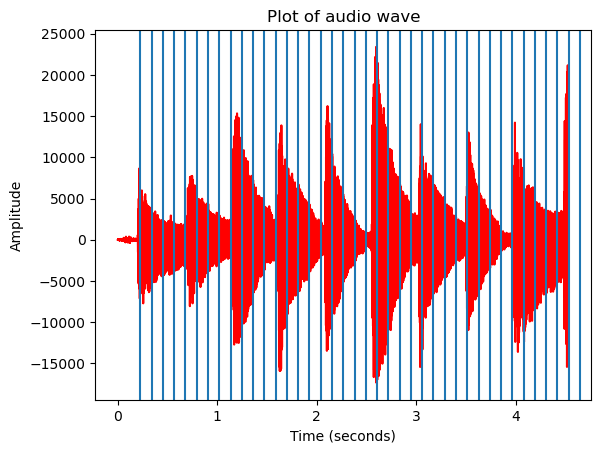

In [89]:
# Return observed state elements as a list of np.arrays called audio_data

# Define arguments
hop_length = 5000
sample_length = 1000
show = 200000
offset = 10000 # TODO Ive added an offset of 10000 for now whilst we havent implemented a solution for the initial silence

performance_path = '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(performance_path)

performance_duration = len(data)/sample_rate

time_samples = np.linspace(0, performance_duration, len(data))
sample_indices = np.arange(offset, len(data), hop_length) 
audio_data = [data[index:index+sample_length] for index in sample_indices]

# Plot data to help visualise it
helper.plot_audio(time_samples[:show], data[:show])
for i in sample_indices[:40]:
    plt.axvline(i/sample_rate)


In [164]:
def viterbi(y: List[np.ndarray], T: np.ndarray, states: List[list], sample_rate: int = 44100, cov_dict: dict = cov_dict):
    """
    Return the optimal state path of the Hidden Markov Model

    Parameters
    y: Observed state sequence
    T: State transition matrix (K, K) of K states
    E: Emission matrix?
    """
    sample_length = len(y[0])
    K = T.shape[0] # Number of states
    no_samples = len(y) # Number of audio samples
    gamma = np.zeros((K, no_samples), 'd') # Matrix to hold probabilities
    delta = np.zeros((K, no_samples), 'B') # Back pointers 
    time_samples = np.linspace(0, sample_length/sample_rate, sample_length)
    
  
    # Initialise prior state (we will assume we start at the first state)
    # TODO think about the inital state and decide what to do about the silence at first
    lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[0], T=0.465, v=2.37, cov_dict=cov_dict)
    gamma[0,0] = 1 * lml # Initialise probability of first audio sample with state 1
    
    # Iterate through the observed audio frames
    for n in range(1, no_samples): # n is the audio frame number
        for k in range(n+1): # Populate the column only up to the max possible state reached
            lml = -helper.stable_nlml(time_samples, y[0], M=9, normalised=False, f=states[k], T=0.465, v=2.37, cov_dict=cov_dict)  
            if k == 0:
                # Case for state 0
                gamma[k, n] = lml + gamma[k, n-1] + T[k,k]
                delta[]
            elif k == n:
                gamma[k,n] = lml + gamma[k-1,n-1] + T[k, k-1]
            elif k > 0 and k < n: 
                gamma[k,n] = np.max([lml + gamma[k,n-1] + T[k, k], lml + gamma[k-1,n-1] + T[k, k-1]])
            else:
                print(k)
                raise(ValueError("Unexpected value for k"))
    print(gamma)

    # for j in range(no_samples):



viterbi(audio_data[:30], T, score )

    

[[-1.59088217e+10 -3.18176434e+10 -4.77264651e+10 ... -4.45447008e+11
  -4.61355829e+11 -4.77264651e+11]
 [ 0.00000000e+00 -2.31489115e+11 -2.47397937e+11 ... -6.45118479e+11
  -6.61027301e+11 -6.76936123e+11]
 [ 0.00000000e+00  0.00000000e+00 -4.02618535e+11 ... -8.00339077e+11
  -8.16247899e+11 -8.32156721e+11]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
